## Import libraries

In [1]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import cv2
import os

## Download dataset from kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samyarr","key":"1a7836e79d6709aea03097158434d3c9"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download samyarr/iranvehicleplatedataset

100% 609M/612M [00:21<00:00, 27.3MB/s]
100% 612M/612M [00:21<00:00, 29.2MB/s]


In [4]:
!mkdir dataset
!cp /content/iranvehicleplatedataset.zip dataset/
!unzip -q /content/dataset/iranvehicleplatedataset.zip -d /content/dataset  

## Inference with TF hub models

In [5]:
IMG_SIZE = 224.0

# loads model from tensorflow hub and returns it
def get_model(module_handle):
  return hub.load(module_handle).signatures["default"]

# returns all images as numpy array
def get_images():
  image_paths = "/content/dataset/Vehicle Plates/Vehicle Plates"
  images = []
  norm_images = []
  for filename in sorted(os.listdir(image_paths)):
    if filename.endswith(".png"):
      im = cv2.imread(os.path.join(image_paths, filename))
      im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
      images.append(im)
      # normalize images [0...1]
      im = (im - im.min())/(im.max() - im.min())
      norm_images.append(im)
  return np.array(images), np.array(norm_images)

# reads bounding box coordinates from xml_file with pascal voc format
def read_content(xml_file):
  tree = ET.parse(xml_file)
  root = tree.getroot()
  for boxes in root.iter('object'):
      ymin, xmin, ymax, xmax = None, None, None, None
      # /IMG_SIZE to normalize it between 0 and 1
      ymin = int(boxes.find("bndbox/ymin").text)
      xmin = int(boxes.find("bndbox/xmin").text)
      ymax = int(boxes.find("bndbox/ymax").text)
      xmax = int(boxes.find("bndbox/xmax").text)
      list_with_single_boxes = [xmin, ymin, xmax, ymax]
  return list_with_single_boxes

# returns all ground truth bounding boxes
def get_gts():
  annot_paths = "/content/dataset/Vehicle Plates annotations/Vehicle Plates annotations"
  gts = []
  for filename in sorted(os.listdir(annot_paths)):
    gts.append(read_content(os.path.join(annot_paths, filename)))
  return np.array(gts)

# computes intersection over union metric
def compute_iou(preds, gts):
  ious = []
  for boxA, boxB in zip(preds, gts):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    ious.append(iou)
  return np.mean(ious)

# does the inference
def inference(model, images):
  preds = []
  for im in tqdm(images):
    tim = tf.convert_to_tensor(np.expand_dims(im, axis=0), dtype=tf.float32)
    result = model(tim)
    im_pred = [0, 0, 0, 0]
    for index, pred_class in enumerate(result["detection_class_entities"].numpy()):
      if pred_class == b'Vehicle registration plate':
        #im_pred.append(np.round(result["detection_boxes"][index].numpy()*IMG_SIZE))
        im_pred[1] = np.round(result["detection_boxes"][index][0].numpy()*IMG_SIZE)
        im_pred[0] = np.round(result["detection_boxes"][index][1].numpy()*IMG_SIZE)
        im_pred[3] = np.round(result["detection_boxes"][index][2].numpy()*IMG_SIZE)
        im_pred[2] = np.round(result["detection_boxes"][index][3].numpy()*IMG_SIZE)
        break
    preds.append(im_pred)
  return np.array(preds)

# plots images
def plot_images(ims, gtruths, number=16):
  images = ims.copy()
  gts = gtruths.copy()
  if number < 4:
    number = 4
  columns = 4
  rows = number//columns if number%columns==0 else number//columns + 1
  fig = plt.figure(figsize=(18,rows*4))
  shuffle = np.random.permutation(images.shape[0])
  images = images[shuffle]
  gts = gts[shuffle]
  for index,im in enumerate(images[:number]):
    fig.add_subplot(rows, columns, index+1)
    tmp = im.copy()
    tmp = cv2.rectangle(tmp, (int(gts[index][0]), int(gts[index][1])), (int(gts[index][2]), int(gts[index][3])), (255, 0, 0), 2)
    plt.imshow(tmp)
  plt.show()

In [6]:
images,norm_images = get_images()
print(images.shape)
print(norm_images.shape)

(313, 224, 224, 3)
(313, 224, 224, 3)


In [7]:
gts = get_gts()
print(gts.shape)

(313, 4)


In [8]:
gts[0]

array([ 58, 130, 141, 157])

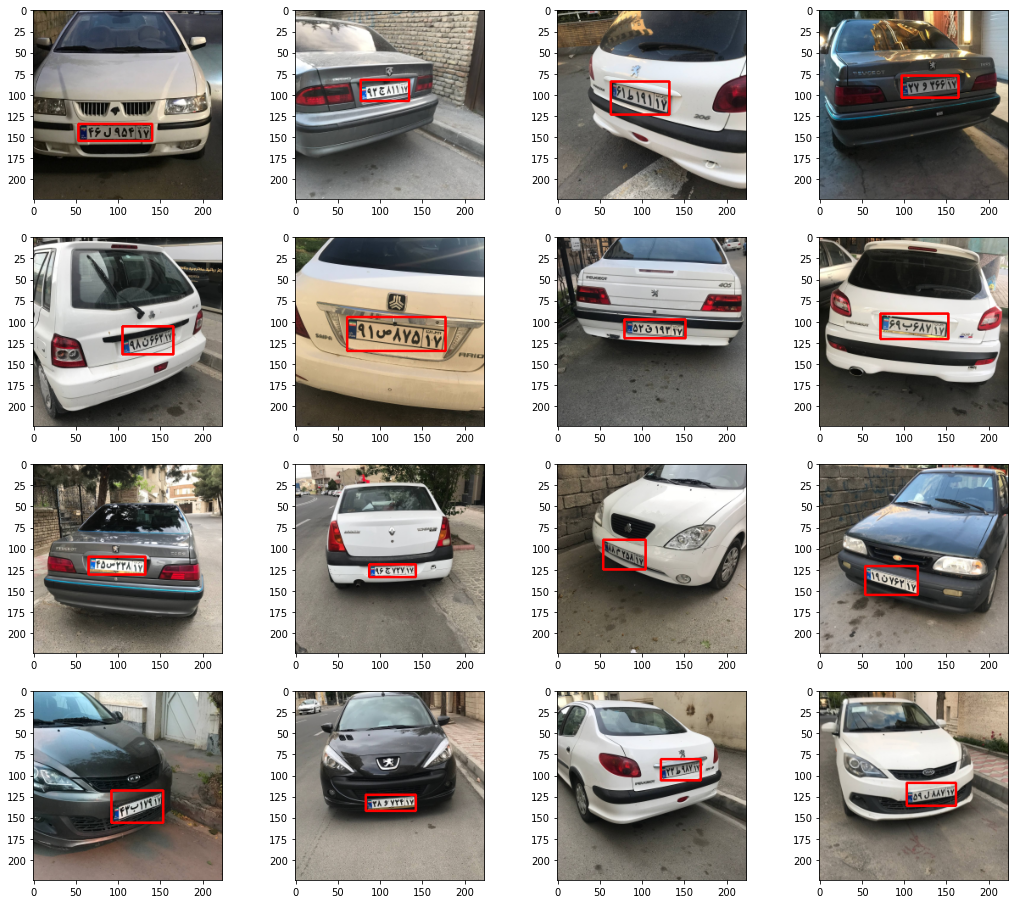

In [9]:
# some images with ground truth bounding boxes
plot_images(images, gts)

In [10]:
model_handles = ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1",
                 "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

In [11]:
predictions = []
ious = []
for handle in model_handles:
  model = get_model(handle)
  preds = inference(model, norm_images)
  iou = compute_iou(preds, gts)
  print("Intersection over Union is", iou)
  predictions.append(preds)
  ious.append(iou)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
100%|██████████| 313/313 [03:55<00:00,  1.33it/s]


Intersection over Union is 0.5904664033899267
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
100%|██████████| 313/313 [12:16<00:00,  2.35s/it]

Intersection over Union is 0.6750646368399816


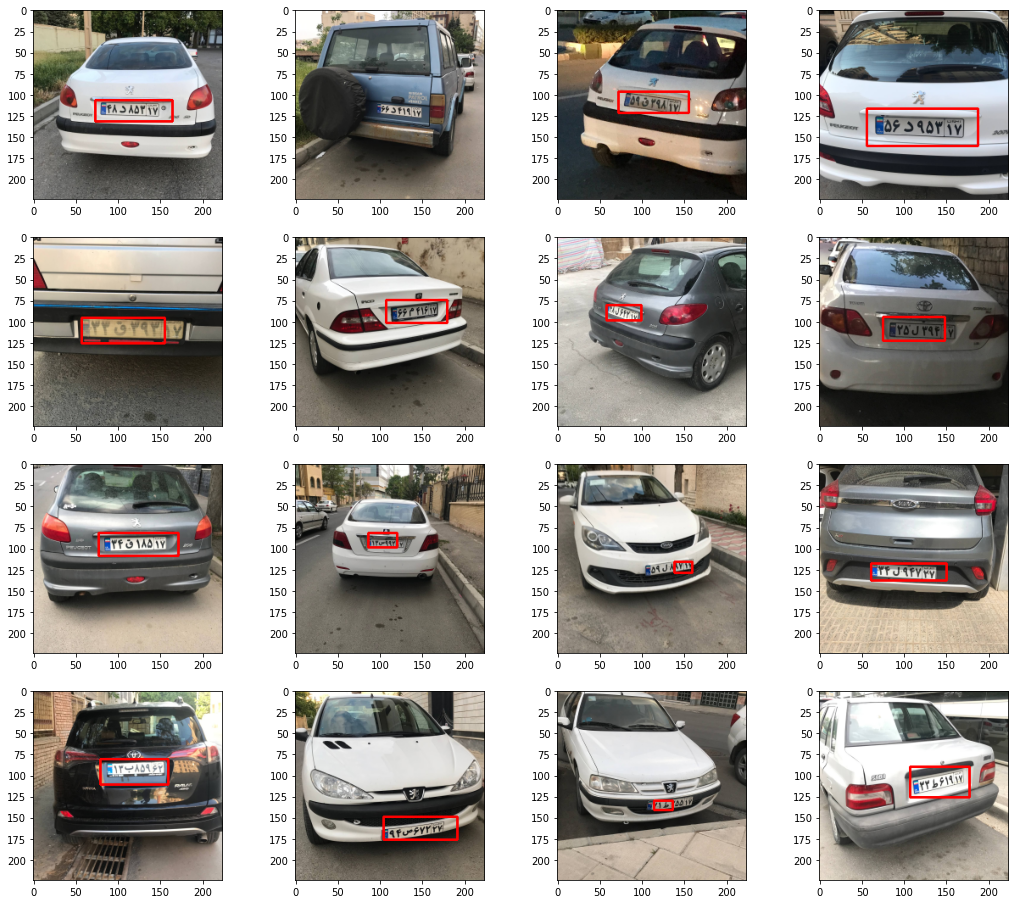

In [12]:
# some predictions from mobilenet
plot_images(images, predictions[0])

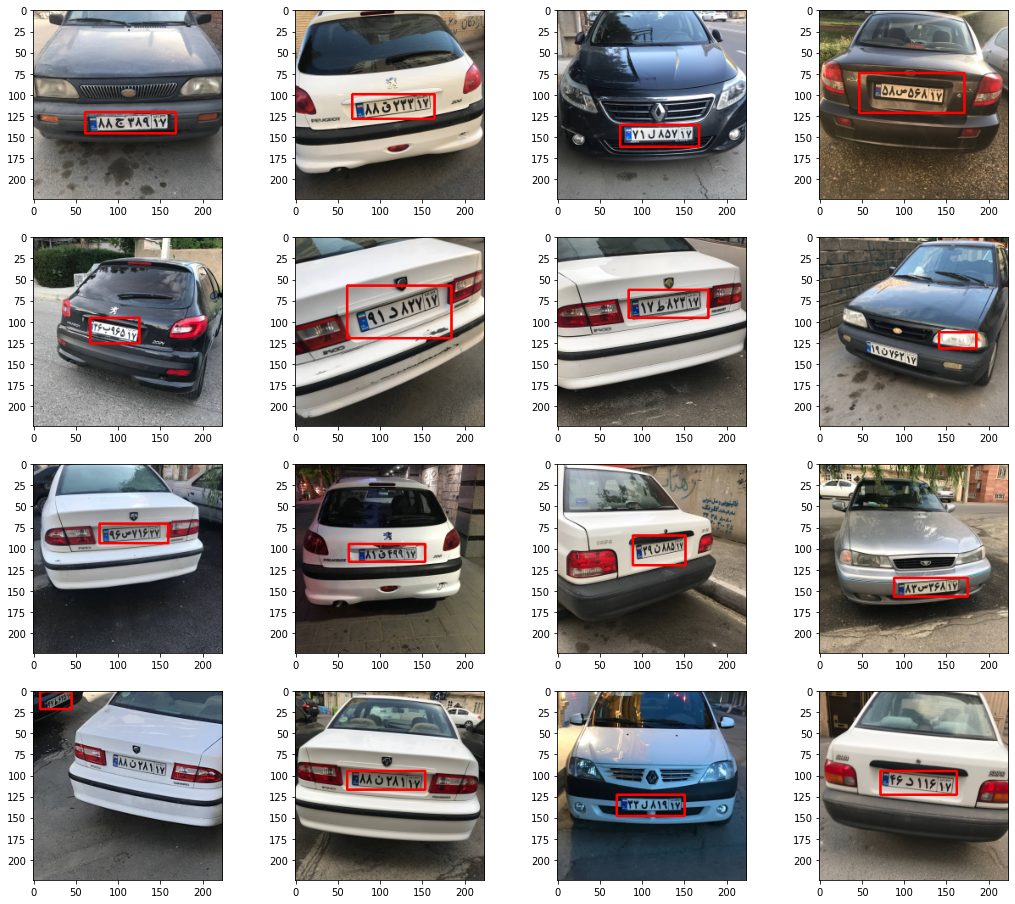

In [13]:
# some predictions from Faster-rcnn
plot_images(images, predictions[1])